## Access ARGO data in Parquet

A jupyter notebook to show how to access and plot ARGO Core data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/4402cb50-e20a-44ee-93e6-4728259250d2).

In [1]:
dataset_name = "argo"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 51ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 892 ms, sys: 168 ms, total: 1.06 s
Wall time: 9.88 s


In [5]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
PLATFORM_NUMBER: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('PLATFORM_NUMBER')
print(list(unique_partition_value)[0:2])  # showing a subset only
len(unique_partition_value)

['5904904', '7900309']
CPU times: user 146 ms, sys: 15.9 ms, total: 162 ms
Wall time: 148 ms


1145

## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


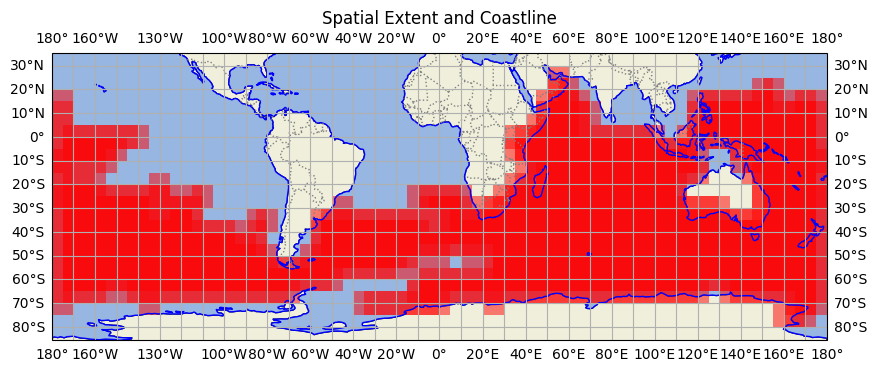

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('1999-10-21 11:46:18'), Timestamp('2024-07-01 04:01:20'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 15:42:37,920 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/argo.parquet
2025-06-05 15:42:38,035 - aodn.GetAodn - WARNING - Old 'dataset_metadata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'DATA_TYPE': {'type': 'string',
  'long_name': 'Data type',
  'conventions': 'Argo reference table 1'},
 'FORMAT_VERSION': {'type': 'string', 'long_name': 'File format version'},
 'HANDBOOK_VERSION': {'type': 'string', 'long_name': 'Data handbook version'},
 'REFERENCE_DATE_TIME': {'type': 'string',
  'long_name': 'Date of reference for Julian days',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_CREATION': {'type': 'string',
  'long_name': 'Date of file creation',
  'conventions': 'YYYYMMDDHHMISS'},
 'DATE_UPDATE': {'type': 'string',
  'long_name': 'Date of update of this file',
  'conventions': 'YYYYMMDDHHMISS'},
 'PLATFORM_NUMBER': {'type': 'string',
  'long_name': 'Float unique identifier',
  'conventions': 'WMO float identifier : A9IIIII'},
 'PROJECT_NAME': {'type': 'string', 'long_name': 'Name of the project'},
 'PI_NAME': {'type': 'string',
  'long_name': 'Name of the principal investigator'},
 'STATION_PARAMETERS': {'type': 'string',
  'long_name': 'List of available parameters fo

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = aodn_dataset.get_data(date_start='2018-12-01', date_end='2023-01-01', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862838 entries, 0 to 862837
Data columns (total 67 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   PROJECT_NAME                  862838 non-null  object        
 1   PI_NAME                       862838 non-null  object        
 2   CYCLE_NUMBER                  862838 non-null  float64       
 3   DIRECTION                     862838 non-null  object        
 4   DATA_CENTRE                   862838 non-null  object        
 5   DC_REFERENCE                  862838 non-null  object        
 6   DATA_STATE_INDICATOR          862838 non-null  object        
 7   DATA_MODE                     862838 non-null  object        
 8   PLATFORM_TYPE                 862838 non-null  object        
 9   FLOAT_SERIAL_NO               862838 non-null  object        
 10  FIRMWARE_VERSION              862838 non-null  object        
 11  WMO_INST_TYPE

<Axes: title={'center': 'Temperature for each location'}, xlabel='TEMP_ADJUSTED', ylabel='PSAL_ADJUSTED'>

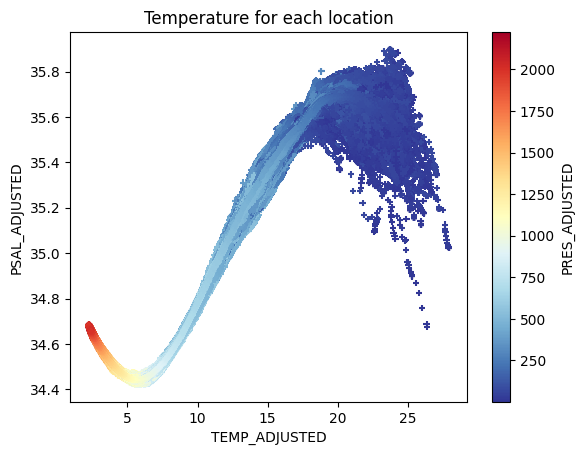

In [11]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

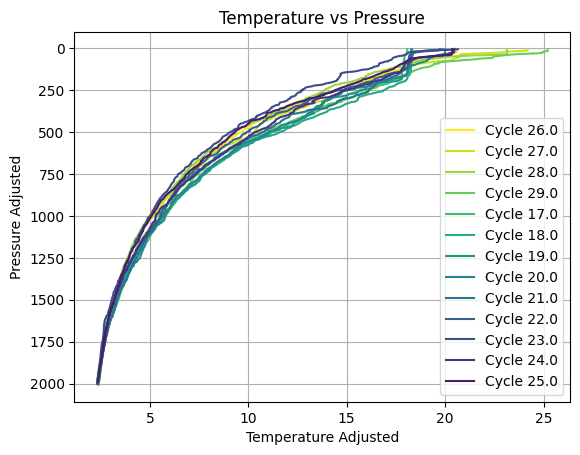

In [12]:
import matplotlib.pyplot as plt


filtered_df = df[df['PLATFORM_NUMBER'] == 5905506]

# Get unique values of CYCLE_NUMBER
unique_cycle_numbers = filtered_df['CYCLE_NUMBER'].unique()

# Define a dictionary to map each unique CYCLE_NUMBER to a color
color_mapping = {cycle_number: plt.cm.viridis_r(i / len(unique_cycle_numbers)) for i, cycle_number in enumerate(unique_cycle_numbers)}

# Plot TEMP_ADJUSTED vs PRES_ADJUSTED with different colors for each line
for cycle_number, color in color_mapping.items():
    cycle_df = filtered_df[filtered_df['CYCLE_NUMBER'] == cycle_number]
    plt.plot(cycle_df['TEMP_ADJUSTED'], cycle_df['PRES_ADJUSTED'], color=color, label=f'Cycle {cycle_number}')

plt.xlabel('Temperature Adjusted')
plt.ylabel('Pressure Adjusted')
plt.title('Temperature vs Pressure')
plt.legend()
plt.grid(True)

# Reverse the y-axis
plt.gca().invert_yaxis()

plt.show()

## Create a TIME and scalar/number filter

In [13]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = aodn_dataset.get_data(date_start='2006-07-12', date_end='2023-02-05', scalar_filter={'PLATFORM_NUMBER': 1901740})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150192 entries, 0 to 150191
Data columns (total 67 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   PROJECT_NAME                  150192 non-null  object        
 1   PI_NAME                       150192 non-null  object        
 2   CYCLE_NUMBER                  150192 non-null  float64       
 3   DIRECTION                     150192 non-null  object        
 4   DATA_CENTRE                   150192 non-null  object        
 5   DC_REFERENCE                  150192 non-null  object        
 6   DATA_STATE_INDICATOR          150192 non-null  object        
 7   DATA_MODE                     150192 non-null  object        
 8   PLATFORM_TYPE                 150192 non-null  object        
 9   FLOAT_SERIAL_NO               150192 non-null  object        
 10  FIRMWARE_VERSION              150192 non-null  object        
 11  WMO_INST_TYPE

<Axes: title={'center': 'Temperature for each location'}, xlabel='TEMP_ADJUSTED', ylabel='PSAL_ADJUSTED'>

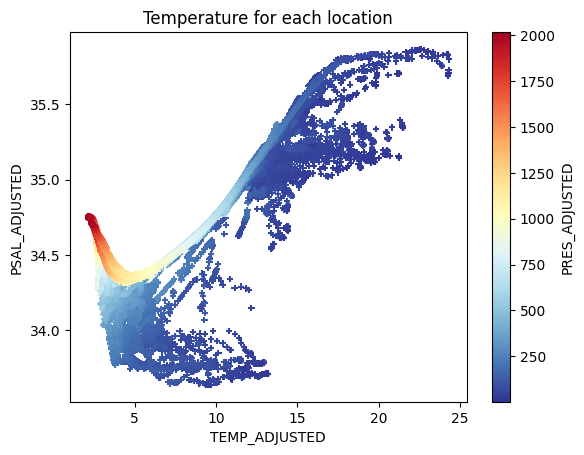

In [14]:
df.plot.scatter(x='TEMP_ADJUSTED', y='PSAL_ADJUSTED', c='PRES_ADJUSTED', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')